In [27]:
import os
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, END,START
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import operator
from IPython.display import display, Markdown,Image

In [9]:
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY=os.getenv('OpenAI_APIKEY')

In [10]:
model = ChatOpenAI(model="gpt-4o", temperature=0,api_key=OPENAI_API_KEY)


In [11]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]  # Conversation history
    user_id: str                            # User identifier
    is_authenticated: bool                  # Auth status
    conversation_length: int                # Track length for dynamic prompts
    uploaded_files: List[dict]              # File context
    user_orders: List[str]                  # Tool-persisted data


In [12]:
@tool
def check_user_orders(user_id: str) -> str:
    """Check user's recent orders. Use when user asks about billing/orders."""
    # Simulate database lookup
    orders = ["Order #123 - Pending", "Order #124 - Shipped"]
    return f"User {user_id} orders:\n" + "\n".join(orders)


In [13]:
@tool
def create_support_ticket(category: str, priority: str, user_id: str) -> str:
    """Create support ticket. Only works for authenticated users."""
    return f"✅ Ticket created: {category} (Priority: {priority}) for user {user_id}"


In [14]:
@tool
def authenticate_user(email: str, password: str) -> str:
    """Authenticate user with email/password."""
    # Simulate auth (in real app, use proper auth service)
    if email.endswith("@customer.com"):
        return "✅ Authentication successful!"
    return "❌ Invalid credentials. Please try again."


In [15]:
tools = [check_user_orders, create_support_ticket, authenticate_user]


# =============================================================================
# DYNAMIC CONTEXT ENGINEERING (Model Context)
# =============================================================================

In [16]:
def create_dynamic_prompt(state: AgentState) -> str:
    """Generate system prompt based on current state."""
    base = "You are a helpful customer support agent for an e-commerce store."
    
    # Conversation length awareness
    if state["conversation_length"] > 10:
        base += "\n🔍 This is a long conversation. Be **extra concise**."
    
    # Authentication status
    if not state["is_authenticated"]:
        base += "\n⚠️ User is NOT authenticated. Ask them to login before sensitive actions."
        base += "\n💡 Use `authenticate_user` tool if they provide credentials."
    
    # File context injection
    if state["uploaded_files"]:
        files = "\n".join([f"- 📄 {f['name']} ({f['type']})" for f in state["uploaded_files"]])
        base += f"\n📁 User uploaded files this session:\n{files}"
        base += "\n💡 Reference these files when answering questions about uploads."
    
    # Available actions summary
    base += "\n\nAVAILABLE ACTIONS:"
    base += "\n- Check orders: `check_user_orders`"
    if state["is_authenticated"]:
        base += "\n- Create tickets: `create_support_ticket`"
    base += "\n- Login: `authenticate_user`"
    
    return base

# =============================================================================
# MAIN AGENT NODE (All Context Layers Combined)
# =============================================================================

In [ ]:
def agent_node(state: AgentState):
    """Main agent logic with full context engineering."""
    
    # 1. MODEL CONTEXT: Dynamic system prompt
    system_prompt = create_dynamic_prompt(state)
    
    # 2. TRANSIENT MESSAGE INJECTION: Add file context if relevant
    messages = state["messages"].copy()
    if state["uploaded_files"] and "file" in messages[-1].content.lower():
        file_context = (
            "💼 **Your uploaded files:**\n" +
            "\n".join([f"• {f['name']}" for f in state["uploaded_files"]])
        )
        messages.append(HumanMessage(content=file_context))
    
    # 3. DYNAMIC TOOL SELECTION: Hide sensitive tools when unauthenticated
    available_tools = tools.copy()
    if not state["is_authenticated"]:
        available_tools = [t for t in tools if t.name != "create_support_ticket"]
    
    # 4. MODEL CALL with full context
    response = model.bind_tools(available_tools).invoke([SystemMessage(content=system_prompt)] + messages)
    
    return {
        "messages": [response],
        "conversation_length": state["conversation_length"] + 1
    }

# =============================================================================
#  BUILD LANGGRAPH WORKFLOW
# =============================================================================

In [28]:
workflow = StateGraph(state_schema=AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools=tools))
workflow.add_edge(START, "agent") 
# Dynamic routing
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)
workflow.add_edge("tools", "agent")


In [29]:
graph = workflow.compile()


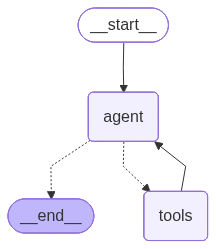

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))


# =============================================================================
# LIVE DEMO - Run these cells one by one
# =============================================================================

In [31]:
# TEST 1: Unauthenticated user
print("\n" + "="*60)
print("📋 TEST 1: Unauthenticated user with billing issue")
state1 = {
    "messages": [HumanMessage(content="I have a billing problem with order #123")],
    "user_id": "user123",
    "is_authenticated": False,
    "conversation_length": 1,
    "uploaded_files": [],
    "user_orders": []
}

result1 = graph.invoke(state1)
display(Markdown(f"**Agent:** {result1['messages'][-1].content}"))
print(f"Auth: {result1['is_authenticated']} | Length: {result1['conversation_length']}")


📋 TEST 1: Unauthenticated user with billing issue


**Agent:** To assist you with your billing problem, I'll need to check your recent orders. However, since this involves sensitive information, please log in first. Could you provide your email and password to proceed with authentication?

Auth: False | Length: 2


In [32]:
# TEST 2: Try to authenticate
print("\n" + "="*60)
print("📋 TEST 2: User tries to authenticate")
state2 = result1.copy()
state2["messages"].append(HumanMessage(content="Login: john@customer.com, pass: secret123"))

result2 = graph.invoke(state2)
display(Markdown(f"**Agent:** {result2['messages'][-1].content}"))
print(f"Auth: {result2['is_authenticated']} | Length: {result2['conversation_length']}")


📋 TEST 2: User tries to authenticate


**Agent:** I've checked your recent orders. Order #123 is currently marked as "Pending." If you have a specific billing issue with this order, please let me know the details so I can assist you further.

Auth: False | Length: 5


In [33]:
# TEST 3: Authenticated + file upload
print("\n" + "="*60)
print("📋 TEST 3: Authenticated user with uploaded invoice")
state3 = result2.copy()
state3["messages"].append(HumanMessage(content="I uploaded invoice.pdf. Create high priority billing ticket."))
state3["uploaded_files"] = [{"name": "invoice.pdf", "type": "pdf", "summary": "Billing invoice Jan 2025"}]
state3["is_authenticated"] = True  # Now authenticated

result3 = graph.invoke(state3)
display(Markdown(f"**Agent:** {result3['messages'][-1].content}"))


📋 TEST 3: Authenticated user with uploaded invoice


**Agent:** A high-priority billing support ticket has been created for you. Our team will review the invoice you uploaded and get back to you shortly. If you have any more questions or need further assistance, feel free to ask!